
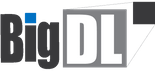
---

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_342"
OpenJDK Runtime Environment (build 1.8.0_342-8u342-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.342-b07, mixed mode)


**Install BigDL Orca**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest pre-release version of BigDL Orca 
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.9 MB 1.8 MB/s 
     |████████████████████████████████| 53.5 MB 285 kB/s 
     |████████████████████████████████| 71.0 MB 402 bytes/s 
     |████████████████████████████████| 35.4 MB 514 kB/s 
     |████████████████████████████████| 218.4 MB 72 kB/s 
INFO: pip is looking at multiple versions of bigdl-orca to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 21.9 MB 1.1 MB/s 
     |████████████████████████████████| 53.5 MB 141 kB/s 
     |████████████████████████████████| 48.2 MB 1.2 MB/s 
     |████████████████████████████████| 197 kB 77.5 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814407 sha256=e5f4efc27b8773887eb819293db0147122e9414bcfc0a4cd4169a713a6bf0c95
  Stored in directory: /root/.cache/pip/wheels/f1/42/b0/ba397759613f4

In [ ]:
# Install required dependencies
!pip install tensorflow==1.15.0 tensorflow-datasets==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 28 kB/s 
     |████████████████████████████████| 3.1 MB 64.8 MB/s 
     |████████████████████████████████| 3.8 MB 68.7 MB/s 
     |████████████████████████████████| 503 kB 76.4 MB/s 
     |████████████████████████████████| 50 kB 9.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f2ded413a5f58b69ca0af31f219586f2f9e75971e0a0dbde850f6deedc682ca5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      

## **Distributed TensorFlow (v1.15) using Orca APIs**

In this guide we will describe how to scale out TensorFlow (v1.15) programs using Orca in 4 simple steps.

In [ ]:
# import necesary libraries and modules
import argparse
from time import time
from tabulate import tabulate
import matplotlib.pyplot as plt
from bigdl.orca.learn.tf.estimator import Estimator
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Define the Model**

You may define your model, loss and metrics in the same way as in any standard (single node) TensorFlow program.

In [ ]:
import tensorflow as tf

def accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1, output_type=labels.dtype)
  is_correct = tf.cast(tf.equal(predictions, labels), dtype=tf.float32)
  return tf.reduce_mean(is_correct)


def lenet(images):
  with tf.variable_scope('LeNet', [images]):
    net = tf.layers.conv2d(images, 32, (5, 5), activation=tf.nn.relu, name='conv1')
    net = tf.layers.max_pooling2d(net, (2, 2), 2, name='pool1')
    net = tf.layers.conv2d(net, 64, (5, 5), activation=tf.nn.relu, name='conv2')
    net = tf.layers.max_pooling2d(net, (2, 2), 2, name='pool2')
    net = tf.layers.flatten(net)
    net = tf.layers.dense(net, 1024, activation=tf.nn.relu, name='fc3')
    logits = tf.layers.dense(net, 10)
    return logits

# tensorflow inputs
images = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1))
# tensorflow labels
labels = tf.placeholder(dtype=tf.int32, shape=(None,))

logits = lenet(images)

loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels))

acc = accuracy(logits, labels)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### **Step 2: Define Train Dataset**

In [ ]:
import tensorflow_datasets as tfds

def preprocess(data):
  data['image'] = tf.cast(data["image"], tf.float32) / 255.
  return data['image'], data['label']

In [ ]:
# get DataSet
mnist_train = tfds.load(name="mnist", split="train")
mnist_test = tfds.load(name="mnist", split="test")

mnist_train = mnist_train.map(preprocess)
mnist_test = mnist_test.map(preprocess)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


### Step 3: Define the train method

In [ ]:
def train_test(cores, epochs):
  OrcaContext.log_output = True
  init_orca_context(cluster_mode="local", cores=4)
  dataset_dir = "~/tensorflow_datasets"
  est = Estimator.from_graph(
    inputs=images,
    outputs=logits,
    labels=labels,
    loss=loss,
    optimizer=tf.train.AdamOptimizer(),
    metrics={"acc": acc}
  )
  tic = time()
  est.fit(data=mnist_train,
    batch_size=320,
    epochs=epochs,
    validation_data=mnist_test
  )
  tac = time()
  fit_time = tac-tic
  return fit_time

### Step 4: Define the iteration method through multiple cores numbers

In [ ]:
def grid_search(min_cores=1, max_cores=4, epochs=1):
  results = []
  for cores in range(min_cores, max_cores+1):
    fit_time = train_test(cores, epochs)
    results.append((cores, fit_time))
  return results

def visualize(model_name, epochs, results):
    xs, ys = [], []
    for datum in results:
      cores, fit_time = datum
      xs.append(cores)
      ys.append(fit_time)
      plt.bar(xs, ys)
    items = zip(xs, ys)
    plt.title(f"{model_name}: {epochs} epochs")
    plt.xlabel("Cores")
    plt.ylabel("Train time (sec)")
    plt.plot()

def tabulate_results(model_name, epochs, results):
    xs, ys = [], []
    for datum in results:
      cores, fit_time = datum
      xs.append(cores)
      ys.append(fit_time/1000)
    items = zip(xs, ys)
    print(tabulate(items, headers=["Cores", "Train time (sec)"], tablefmt="github"))

### Iterate from 1 to 4 cores for 1 epoch

In [ ]:
model_name = "LeNet"
min_cores=1
max_cores=4
epochs=1
results1 = grid_search(
  min_cores=min_cores,
  max_cores=max_cores,
  epochs=epochs
)

Initializing orca context


/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)



Instructions for updating:
Use `tf.cast` instead.






creating: createFakeOptimMethod
creating: createStatelessMetric


creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 17:45:17.088 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 17:45:17.090 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 17:45:17.092 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 17:45:17.094 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 17:45:21.499 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 17:45:21.505 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - caching training rdd ...
2022-09-18 

/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createFakeOptimMethod
creating: createStatelessMetric
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 17:46:53.621 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 17:46:53.624 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 17:46:53.625 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 17:46:53.642 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 17:46:55.963 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 17:46:55.965 [Thread-4] INFO  com.intel.analytics.bigdl.dll

/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createFakeOptimMethod
creating: createStatelessMetric
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 17:48:25.651 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 17:48:25.652 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 17:48:25.652 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 17:48:25.653 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 17:48:28.697 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 17:48:28.699 [Thread-4] INFO  com.intel.analytics.bigdl.dll

/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createFakeOptimMethod
creating: createStatelessMetric
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 17:50:03.480 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 17:50:03.484 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 17:50:03.484 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 17:50:03.485 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 17:50:07.610 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 17:50:07.611 [Thread-4] INFO  com.intel.analytics.bigdl.dll

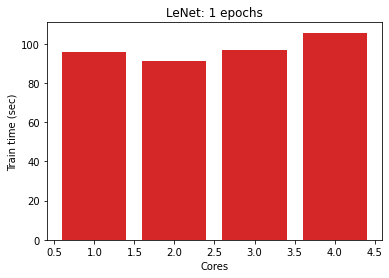

In [ ]:
visualize(model_name, epochs, results1)

In [ ]:
tabulate_results(model_name, epochs, results1)

|   Cores |   Train time (sec) |
|---------|--------------------|
|       1 |          0.0958894 |
|       2 |          0.0912497 |
|       3 |          0.0968815 |
|       4 |          0.105716  |


### Train for 10 epochs

In [ ]:
model_name = "LeNet"
min_cores=1
max_cores=4
epochs=10
results2 = grid_search(
  min_cores=min_cores,
  max_cores=max_cores,
  epochs=epochs
)

Initializing orca context


/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createFakeOptimMethod
creating: createStatelessMetric
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 17:58:06.474 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 17:58:06.476 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 17:58:06.477 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 17:58:06.485 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 17:58:13.281 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 17:58:13.282 [Thread-4] INFO  com.intel.analytics.bigdl.dll

/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createFakeOptimMethod
creating: createStatelessMetric
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 18:12:59.707 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 18:12:59.709 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 18:12:59.711 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 18:12:59.713 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 18:13:05.786 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 18:13:05.786 [Thread-4] INFO  com.intel.analytics.bigdl.dll

/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createFakeOptimMethod
creating: createStatelessMetric
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 18:28:26.365 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 18:28:26.371 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 18:28:26.371 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 18:28:26.372 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 18:28:34.507 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 18:28:34.508 [Thread-4] INFO  com.intel.analytics.bigdl.dll

/usr/local/lib/python3.7/dist-packages/bigdl/orca/common.py:251: Warning: Use an existing SparkContext, cluster_mode is determined by the existing SparkContext
  "cluster_mode is determined by the existing SparkContext", Warning)


creating: createFakeOptimMethod
creating: createStatelessMetric
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
2022-09-18 18:44:24.543 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-09-18 18:44:24.544 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 4
2022-09-18 18:44:24.545 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 14
2022-09-18 18:44:24.547 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-09-18 18:44:32.640 [Thread-4] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - TFTrainingHelperV2[TFParkTraining] isTorch is false
2022-09-18 18:44:32.641 [Thread-4] INFO  com.intel.analytics.bigdl.dll

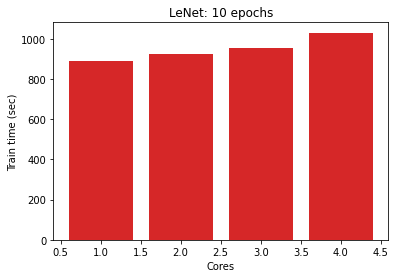

In [ ]:
visualize(model_name, epochs, results2)

In [ ]:
tabulate_results(model_name, epochs, results2)

|   Cores |   Train time (sec) |
|---------|--------------------|
|       1 |           0.891112 |
|       2 |           0.925016 |
|       3 |           0.956362 |
|       4 |           1.03112  |
